In [4]:
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt

In [5]:
with open('train.json', 'r') as handle:
    json_data = [json.loads(line) for line in handle]
myKeys = set()
mygenres = set()
genres =[]
plot = []
for i in range(len(json_data)):
    if 'genres' in json_data[i].keys():
        a = json_data[i]['genres']
        genres.append(a.values())
        plot.append(json_data[i]['plot_summary'])
        mygenres.update(a.values())
        myKeys.update(a.keys())


I want to know the plots length distribution, in order to decide how to feed the seq embeddings model. (I wanted to feed it with the start and with the end of each plot, but I didn't realized this)

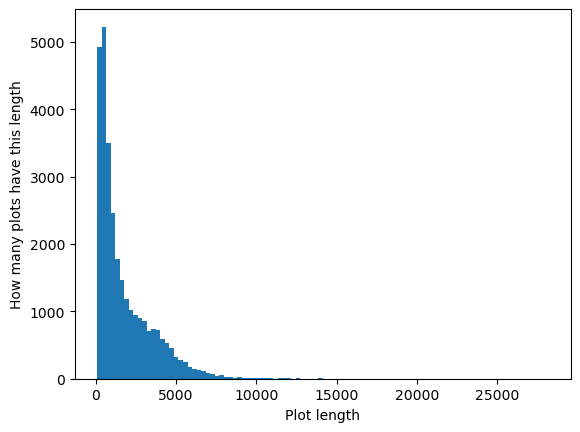

In [6]:
x = [len(l) for l in plot]
plt.hist(x, density=False, bins=100)  # density=False would make counts
plt.ylabel('How many plots have this length')
plt.xlabel('Plot length');
plt.show()

In [7]:
df = pd.DataFrame(columns = mygenres)
mlb = MultiLabelBinarizer()
mlb_result = mlb.fit_transform(genres)
df1 = pd.concat([pd.DataFrame(genres), pd.DataFrame(mlb_result,columns=list(mlb.classes_))],axis=1)#

In [8]:
# drop the irrelevant columns:
df2 = df1.drop(df1.iloc[:, 0:16].columns, axis=1)

# Before I clean the data, I concat plots to their labels:

In [9]:
df3 = pd.DataFrame(plot)
df4 = pd.concat((df3.rename(columns={df3.columns[0]: 'Plots'}), df2), axis=1)

In [10]:
categories_per_plot = df2.sum(axis=1).values
for i in reversed(range(categories_per_plot.shape[0])):
    if categories_per_plot[i] == 0:
        df4 = df4.drop(labels=df4.iloc[i].name, axis=0)
print("This step cleaned", df2.shape[0]-df4.shape[0], "unlabeled plots")

This step cleaned 279 unlabeled plots


In [11]:
categories_per_plot2 = df4.iloc[:, 1:df4.shape[1]].sum(axis=1)
print(" Average number of categories per plot:", np.average(categories_per_plot2))

 Average number of categories per plot: 3.5938670175083494


After I had low quality results, I decided to remove rare categories.
I made ***a significant efforts*** to find an optimal balance between number of categories to the lost of data samples.
Finally I drew back and deleted this code.

In [12]:
# Save a tiny dataset in order to check the flow
df5 = df4.iloc[0:300, :]

In [13]:
df5.to_csv(path_or_buf='300.csv', index=False, header=False)

# Pruning the rare categories
(only results, without the code)

Below is an example from my tests to find a good trade off between decreasing the sparsity of the data and to the lost of data samples.

There are 356 classes. 
 I used pruning_thresholds of [1, 2, 3, 4, 5, 10, 50] After pruning, there were  [333, 282, 268, 231, 154] number of classes, respective to the above thresholds.


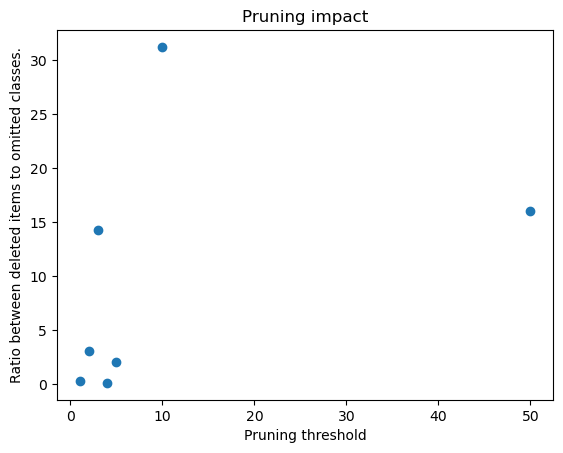

In [14]:
pruning_threshold= [ 1, 2, 3, 4, 5, 10,50]
omitted_classes = [23, 25, 14, 12, 14, 37, 77]
deleted_items = [5, 76, 200, 1, 28, 1155, 1231]
print("There are 356 classes. \n I used pruning_thresholds of",pruning_threshold,"After pruning, there were " , [333, 282, 268, 231, 154], "number of classes, respective to the above thresholds.")
ratio = [i / j for i, j in zip(deleted_items, omitted_classes)]
plt.scatter(pruning_threshold, ratio)
plt.title('Pruning impact')
plt.xlabel("Pruning threshold")
plt.ylabel("Ratio between deleted items to omitted classes.")
plt.show()

# I choose not to do any pruning because it didn't reduce enough the sparsity.